In [237]:
#import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import overpy

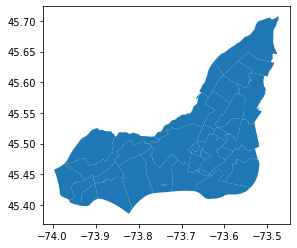

In [261]:
# Read shapefile and plot the boundaries
shapefile_path = "LIMADMIN.shp"
montreal_gdf = gpd.read_file(shapefile_path)
montreal_gdf.plot()
plt.show()

In [262]:
# Ensure CRS is set and get total bounds
equal_area_crs = "EPSG:4609"
if montreal_gdf.crs is None:
    montreal_gdf.crs = equal_area_crs
montreal_gdf = montreal_gdf.to_crs(equal_area_crs)
total_bounds = montreal_gdf.total_bounds


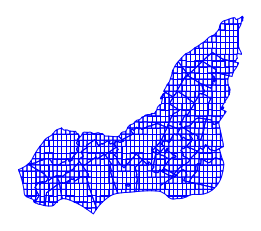

In [264]:
# Create a fishnet grid
def create_fishnet_grid(bounds, cell_width, cell_height):
    min_x, min_y, max_x, max_y = bounds
    x_coords = np.arange(min_x, max_x, cell_width)
    y_coords = np.arange(min_y, max_y, cell_height)
    
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)
    x1, y1 = x_grid.flatten(), y_grid.flatten()
    x2, y2 = x1 + cell_width, y1
    x3, y3 = x1 + cell_width, y1 + cell_height
    x4, y4 = x1, y1 + cell_height
    
    polygons = [Polygon([(x1[i], y1[i]), (x2[i], y2[i]), (x3[i], y3[i]), (x4[i], y4[i])]) for i in range(len(x1))]
    
    grid = gpd.GeoDataFrame({"geometry": polygons})
    return grid

# Define the dimensions of the grid cells
cell_width = 0.01  # Adjust this value as needed
cell_height = 0.01  # Adjust this value as needed

# Create the fishnet grid
fishnet_grid = create_fishnet_grid(total_bounds, cell_width, cell_height)

#set CRS of fishnet equal to gdf
if fishnet_grid.crs is None:
    fishnet_grid = fishnet_grid.set_crs(epsg=4609)  # Set the CRS to EPSG:4609 (NAD83)

montreal_grid = gpd.overlay(fishnet_grid, montreal_gdf, how="intersection")

montreal_grid.to_file("montreal_fishnet_grid.shp") #outputs the fishnet to a file

#show fishnet

shapefile_path_mtl = "montreal_fishnet_grid.shp"

montreal_grid = gpd.read_file(shapefile_path_mtl)

montreal_grid.plot(edgecolor='blue', facecolor='none')
plt.axis('off')
plt.show()

In [239]:
#get OSM data of cultural and arts venuues in Montreal using Overpass API and output as json

# Define the Overpass API query for Montreal
overpass_query = """
[out:json];
(
node["amenity"~"arts_centre|theatre"](45.4200,-73.7100,45.7300,-73.4000);
way["amenity"~"arts_centre|theatre"](45.4200,-73.7100,45.7300,-73.4000);
rel["amenity"~"arts_centre|theatre"](45.4200,-73.7100,45.7300,-73.4000);
node["tourism"~"museum|gallery"](45.4200,-73.7100,45.7300,-73.4000);
way["tourism"~"museum|gallery"](45.4200,-73.7100,45.7300,-73.4000);
rel["tourism"~"museum|gallery"](45.4200,-73.7100,45.7300,-73.4000);
);
out center;
"""


# Initialize the Overpass API client
api = overpy.Overpass()

# Send the query and get the response
result = api.query(overpass_query)

#print(result)


In [240]:
# Extract data and convert to GeoDataFrame

# Function to extract relevant data from Overpass API result
def extract_data(result):
    data = []
    for node in result.nodes:
        data.append({"id": node.id, "lat": node.lat, "lon": node.lon, "tags": node.tags})
    for way in result.ways:
        data.append({"id": way.id, "lat": way.center_lat, "lon": way.center_lon, "tags": way.tags})
    for rel in result.relations:
        data.append({"id": rel.id, "lat": rel.center_lat, "lon": rel.center_lon, "tags": rel.tags})
    return data


extracted_data = extract_data(result) # Extract data from the Overpass API result
df = pd.DataFrame(extracted_data) # Create a pandas DataFrame from the extracted data

# To print the DataFrame print(df)


#convert into geodataframe
df["geometry"] = df.apply(lambda x: Point((float(x.lon), float(x.lat))), axis=1) # Create a geometry column from the lat and lon columns

# Convert the DataFrame to a GeoDataFrame with crs of montreal
gdf = gpd.GeoDataFrame(df, geometry = 'geometry',crs="EPSG:4609")

# Print the GeoDataFrame print(gdf)

In [241]:
#create a column for type of venue
gdf['type'] = gdf['tags'].apply(lambda x: x['amenity'] if 'amenity' in x else x['tourism'])

# Print the GeoDataFrame: print(gdf)

In [243]:
#merge data and grid


merged = gpd.sjoin(montreal_grid, gdf, how="left", predicate="intersects") # Merge the GeoDataFrames

# Print the first 5 rows of the merged GeoDataFrame: print(merged.head())


In [244]:
# Create a pivot table with the counts of venues by type for each grid cell

pivot_table = merged.pivot_table(values='id', index='index_right', columns='type', aggfunc='count', fill_value=0)
total_venues = pivot_table.sum(axis=1) # Calculate the total number of venues per grid cell
main_venue = pivot_table.idxmax(axis=1) # Find the most frequent venue type for each grid cell

# Add the 'total_venues' and 'main_venue' columns to the montreal_grid GeoDataFrame
montreal_grid['total_venues'] = total_venues
montreal_grid['main_venue'] = main_venue


In [214]:
print(pivot_table.head())

print("Unique index_right values:", len(merged['index_right'].unique()))

#calculate number of grid cells
print("Number of grid cells:", len(montreal_grid))

print("Number of unique venues in gdf:", len(gdf))

print("Number of unique grid cells in montreal_grid:", len(montreal_grid))

print("Number of unique grid cells with venues in merged:", merged['index_right'].nunique())

print("Distribution of venues per grid cell in merged:")

print(merged.groupby("index_right").size().value_counts())


type         arts_centre  community_centre  events_venue  gallery  museum  \
index_right                                                                 
0.0                    0                 0             0        0       1   
1.0                    0                 0             0        0       1   
2.0                    0                 0             0        0       0   
3.0                    0                 0             0        0       0   
4.0                    0                 0             0        0       0   

type         theatre  
index_right           
0.0                0  
1.0                0  
2.0                1  
3.0                1  
4.0                1  
Unique index_right values: 142
Number of grid cells: 1238
Number of unique venues in gdf: 154
Number of unique grid cells in montreal_grid: 1238
Number of unique grid cells with venues in merged: 141
Distribution of venues per grid cell in merged:
1    141
dtype: int64


In [245]:
# Define the CRS for montreal_grid (if not already defined)
if montreal_grid.crs is None:
    montreal_grid = montreal_grid.set_crs(epsg=4609)  # Set the CRS to EPSG:4609 (NAD83)

# Check the CRS of both GeoDataFrames
print("CRS of gdf:", gdf.crs)
print("CRS of montreal_grid:", montreal_grid.crs)

# Reproject gdf to match the CRS of montreal_grid (if needed)
if gdf.crs != montreal_grid.crs:
    gdf = gdf.to_crs(montreal_grid.crs)
    print("Reprojected gdf to CRS:", gdf.crs)


CRS of gdf: EPSG:4609
CRS of montreal_grid: EPSG:4609


In [205]:
# Step 1: Assign a default value of 0 to the 'total_venues' column for all grid cells
montreal_grid['total_venues'] = 0

# Step 2: Count the number of venues per grid cell in the 'merged' DataFrame
venue_count_per_grid_cell = merged.groupby("index_right").size()

# Step 3: Update the 'total_venues' column in the 'montreal_grid' DataFrame
montreal_grid.loc[venue_count_per_grid_cell.index, 'total_venues'] = venue_count_per_grid_cell.values

# Print the updated 'montreal_grid' DataFrame
print(montreal_grid)


      MUNID CODEID CODEMAMROT           NOM        TYPE ABREV  NUM  \
0     66023     46      66107  Beaconsfield  Ville liée    BF    7   
1     66023     46      66107  Beaconsfield  Ville liée    BF    7   
2     66023     46      66107  Beaconsfield  Ville liée    BF    7   
3     66023     46      66107  Beaconsfield  Ville liée    BF    7   
4     66023     46      66107  Beaconsfield  Ville liée    BF    7   
...     ...    ...        ...           ...         ...   ...  ...   
1233  66023     60      66007  Montréal-Est  Ville liée    ME   74   
1234  66023     60      66007  Montréal-Est  Ville liée    ME   74   
1235  66023     60      66007  Montréal-Est  Ville liée    ME   74   
1236  66023     60      66007  Montréal-Est  Ville liée    ME   74   
1237  66023     60      66007  Montréal-Est  Ville liée    ME   74   

              AIRE      PERIM  \
0     2.492251e+07  23295.573   
1     2.492251e+07  23295.573   
2     2.492251e+07  23295.573   
3     2.492251e+07  23295.5

In [206]:
#print head
print(montreal_grid.head())

   MUNID CODEID CODEMAMROT           NOM        TYPE ABREV  NUM         AIRE  \
0  66023     46      66107  Beaconsfield  Ville liée    BF    7  24922505.75   
1  66023     46      66107  Beaconsfield  Ville liée    BF    7  24922505.75   
2  66023     46      66107  Beaconsfield  Ville liée    BF    7  24922505.75   
3  66023     46      66107  Beaconsfield  Ville liée    BF    7  24922505.75   
4  66023     46      66107  Beaconsfield  Ville liée    BF    7  24922505.75   

       PERIM                                           geometry  total_venues  \
0  23295.573  POLYGON ((-73.83660 45.39540, -73.83660 45.392...             1   
1  23295.573  POLYGON ((-73.83660 45.39540, -73.82660 45.395...             1   
2  23295.573  POLYGON ((-73.82660 45.39540, -73.81660 45.395...             1   
3  23295.573  POLYGON ((-73.81660 45.39540, -73.81546 45.395...             1   
4  23295.573  POLYGON ((-73.86660 45.40540, -73.86660 45.404...             1   

  main_venue  
0     museum  
1 

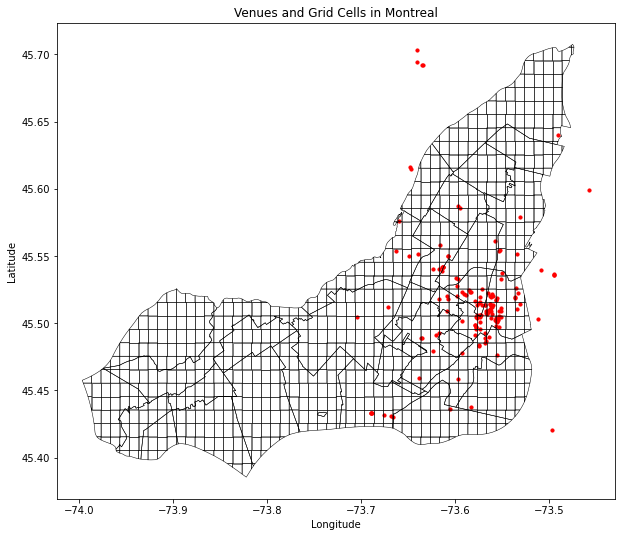

In [247]:
#what it looks like until now

fig, ax = plt.subplots(figsize=(10, 10))
montreal_grid.boundary.plot(ax=ax, color='black', linewidth=0.5)
gdf.plot(ax=ax, color='red', markersize=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Venues and Grid Cells in Montreal')
plt.show()


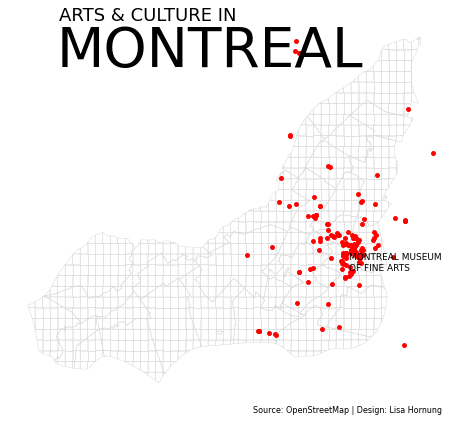

In [258]:
#Just the visualization
# Plot
fig, ax = plt.subplots(figsize=(8, 8))  # Reduce figsize to create a smaller figure

# Plot grid cell boundaries
montreal_grid.boundary.plot(ax=ax, color="#DADADA", zorder=2, linewidth=0.5)

# Plot venues as colored dots
gdf.plot(ax=ax, markersize=15, color="red", zorder=3)  # Specify color and size of dots

# Add labels for places
for i, place in places_gdf.iterrows():
    ax.text(place["geometry"].x + 0.01, place["geometry"].y, place.name.upper(),
            va="center_baseline", ha="left", fontsize=9)

# Remove axis
ax.axis("off")

# Title and source text
plt.figtext(0.215, 0.88 - 0.05, "Arts & culture in".upper(), fontsize=18, ha="left")
plt.figtext(0.21, 0.8 - 0.05, "Montreal".upper(), fontsize=55, ha="left")
plt.figtext(0.88, 0.15, "Source: OpenStreetMap | Design: Shafkat Rahman", fontsize=8, ha="right")

plt.show()


In [249]:
# Define places of interest

places_dict = {
    "Montreal Museum\nof Fine Arts": [45.498686, -73.580011]
}

places_df = pd.DataFrame.from_dict(places_dict, orient="index", columns=["lat", "lon"])
geometry = [Point(xy) for xy in zip(places_df['lon'], places_df['lat'])]
places_gdf = gpd.GeoDataFrame(places_df, crs="EPSG:4326", geometry=geometry)
places_gdf = places_gdf.to_crs(montreal_grid.crs)

In [252]:
# Find all the unique venue types in the 'type' column of the gdf GeoDataFrame to make colormap dictionary
unique_venue_types = gdf['type'].unique()

# Print the unique venue types 
print(unique_venue_types)

['museum' 'theatre' 'gallery' 'arts_centre' 'events_venue'
 'community_centre']


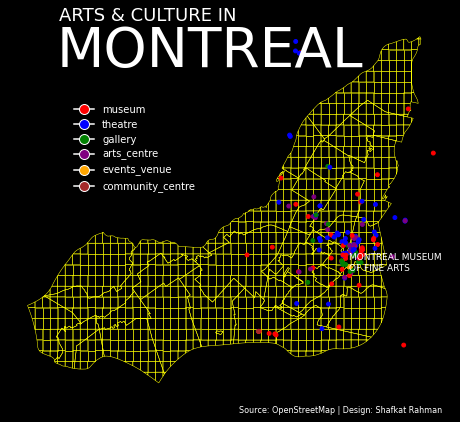

In [253]:
# Define a colormap dictionary to assign unique colors to each venue type
colormap = {
    'museum': 'red',
    'theatre': 'blue',
    'gallery': 'green',
    'arts_centre': 'purple',
    'events_venue': 'orange',
    'community_centre': 'brown'
}

# Create a new column 'color' in the gdf GeoDataFrame based on the 'type' column using the colormap
gdf['color'] = gdf['type'].map(colormap)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))  # Reduce figsize to create a smaller figure

# Set the facecolor of the plot to black
fig.set_facecolor('black')

# Plot grid cell boundaries and map boundary as black
montreal_grid.boundary.plot(ax=ax, color="yellow", zorder=2, linewidth=0.5)

# Plot venues as colored dots based on the 'color' column
gdf.plot(ax=ax, markersize=15, color=gdf['color'], zorder=3)

# Add labels for places
for i, place in places_gdf.iterrows():
    ax.text(place["geometry"].x + 0.01, place["geometry"].y, place.name.upper(),
            va="center_baseline", ha="left", fontsize=9, color='white')

# Remove axis
ax.axis("off")

# Title and source text
plt.figtext(0.215, 0.88 - 0.05, "Arts & culture in".upper(), fontsize=18, ha="left", color='white')
plt.figtext(0.21, 0.8 - 0.05, "Montreal".upper(), fontsize=55, ha="left", color='white')
plt.figtext(0.88, 0.15, "Source: OpenStreetMap | Design: Shafkat Rahman", fontsize=8, ha="right", color='white')

# Create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=venue_type)
                   for venue_type, color in colormap.items()]
legend = ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.13, 0.8), frameon=False)

# Set the text color of the legend to white
plt.setp(legend.get_texts(), color='white')

# If you want to change the color of the legend title (if any), you can use the following line:
# legend.get_title().set_color('white')


plt.show()

In [257]:
#Making it interactive using folium

# Extract the name from the 'tags' column and create a new column 'name'
gdf['name'] = gdf['tags'].apply(lambda x: x.get('name', ''))

# Define a colormap dictionary to assign unique colors to each venue type
colormap = {
    'museum': 'red',
    'theatre': 'blue',
    'gallery': 'green',
    'arts_centre': 'purple',
    'events_venue': 'orange',
    'community_centre': 'brown'
}

# Create a new column 'color' in the gdf GeoDataFrame based on the 'type' column using the colormap
gdf['color'] = gdf['type'].map(colormap)

# Create a folium map centered at the mean latitude and longitude of the venues
m = folium.Map(location=[gdf['lat'].mean(), gdf['lon'].mean()], zoom_start=13)

# Add markers for each venue
for i, row in gdf.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=folium.Popup(row['name'] + ' (' + row['type'] + ')', parse_html=True), # Name of the venue+type to be displayed on click
        icon=folium.Icon(color=row['color'])  # Color of the marker based on venue type
    ).add_to(m)

# Display the map
m


/var/folders/rg/mwxswyvj085f5x_f4wqwmyx80000gn/T/ipykernel_19176/2773032415.py:27: UserWarning:

color argument of Icon should be one of: {'beige', 'orange', 'red', 'lightgreen', 'black', 'blue', 'gray', 'lightred', 'darkblue', 'darkpurple', 'pink', 'cadetblue', 'purple', 'darkgreen', 'lightblue', 'lightgray', 'white', 'green', 'darkred'}.

